## 0. Libraries + meta params

#### Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import utils.data_processing as data_processing
import utils.visualize as visualize
import json
import pprint
import os

import torch

from IPython.display import clear_output
from torchmetrics import ConfusionMatrix
import seaborn as sns

/home/wrongwizzli/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/wrongwizzli/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
device

'cuda'

#### Config setup

In [3]:
config = json.load(open("config.json", "r"))
using_wide_seq = True

In [4]:
if using_wide_seq:
    ACTIVITY_THRESHOLD = config["activity_threshold_wide"]
    SEQUENCE_LENGTH = config["sequence_length_wide"]
else:
    ACTIVITY_THRESHOLD = config["activity_threshold"]
    SEQUENCE_LENGTH = config["sequence_length"]

start_week = config["start_week"]
start_week = datetime.datetime.strptime(start_week, "%d.%m.%Y")

data_path = os.path.join("./data", config["dataset_filename"])

## 1. Read data

In [5]:
df = pd.read_csv(data_path)
df.head(2)

,datasetname,n_tasks,label
0,mc16_13TeV:mc16_13TeV.300000.Pythia8BPhotospp_...,"{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",0
1,mc16_13TeV:mc16_13TeV.301000.PowhegPythia8EvtG...,"{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",0


In [6]:
def retrieve_sequence_from_string(n_tasks: str):
    str_values = n_tasks[1:-1].split(',')
    return [int(str_value) for str_value in str_values]


list_sequences = df['n_tasks'].apply(retrieve_sequence_from_string).to_list()
numpy_sequences = np.array(list_sequences)

## 2. Preprocessing

In [97]:
active_datasets = numpy_sequences[numpy_sequences.sum(axis=1) > ACTIVITY_THRESHOLD]
active_datasets.shape

(3885, 305)

In [98]:
train_data, test_data = train_test_split(active_datasets, test_size=0.15)
train_data.shape, test_data.shape

((3302, 305), (583, 305))

#### Get balanced by Y weeks from dataset

##### Find balanced weeks

In [99]:
is_full_zeros = np.zeros(active_datasets.shape)
for i in tqdm(range(is_full_zeros.shape[0])):
    for j in range(is_full_zeros.shape[1]):
        left_idx = max(0, j - SEQUENCE_LENGTH - 1)
        is_full_zeros[i, j] = (active_datasets[i, left_idx : (j + 1)].sum() == 0)
        
full_zeros_by_week = is_full_zeros.sum(axis=0)
accesses_by_week = (active_datasets > 0).sum(axis=0)

100%|██████████| 3885/3885 [00:02<00:00, 1378.87it/s]


<BarContainer object of 305 artists>

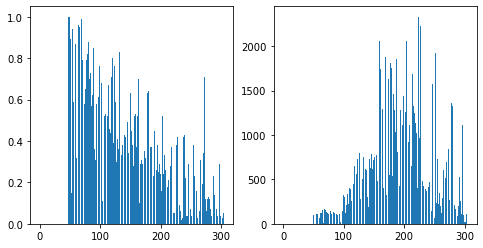

In [100]:
accesses_by_week_freq = accesses_by_week / (active_datasets.shape[0] - full_zeros_by_week + 1e-8)
accesses_by_week_freq = np.round(accesses_by_week_freq, 2)
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(4)
fig.set_figwidth(8)
ax[0].bar(np.arange(accesses_by_week_freq.shape[0]), accesses_by_week_freq)
ax[1].bar(np.arange(accesses_by_week_freq.shape[0]), accesses_by_week)

In [101]:
# We want to get weeks where percentage of accesses to all datasets was from 0.4 to 0.6
optimal_weeks = np.nonzero((accesses_by_week_freq > 0.4) & (accesses_by_week_freq < 0.6))[0]
optimal_weeks_dates = [start_week + datetime.timedelta(weeks=int(week)) for week in optimal_weeks]
dict(sorted(zip(optimal_weeks_dates, accesses_by_week_freq[optimal_weeks])))

{datetime.datetime(2018, 7, 29, 0, 0): 0.59,
 datetime.datetime(2018, 8, 12, 0, 0): 0.56,
 datetime.datetime(2018, 8, 26, 0, 0): 0.44,
 datetime.datetime(2018, 12, 2, 0, 0): 0.58,
 datetime.datetime(2019, 2, 24, 0, 0): 0.57,
 datetime.datetime(2019, 3, 24, 0, 0): 0.57,
 datetime.datetime(2019, 4, 14, 0, 0): 0.59,
 datetime.datetime(2019, 4, 21, 0, 0): 0.58,
 datetime.datetime(2019, 7, 7, 0, 0): 0.47,
 datetime.datetime(2019, 7, 21, 0, 0): 0.52,
 datetime.datetime(2019, 7, 28, 0, 0): 0.43,
 datetime.datetime(2019, 8, 4, 0, 0): 0.53,
 datetime.datetime(2019, 8, 25, 0, 0): 0.52,
 datetime.datetime(2019, 9, 15, 0, 0): 0.46,
 datetime.datetime(2019, 9, 22, 0, 0): 0.59,
 datetime.datetime(2019, 9, 29, 0, 0): 0.44,
 datetime.datetime(2019, 10, 27, 0, 0): 0.58,
 datetime.datetime(2019, 11, 24, 0, 0): 0.59,
 datetime.datetime(2019, 12, 22, 0, 0): 0.41,
 datetime.datetime(2020, 1, 5, 0, 0): 0.48,
 datetime.datetime(2020, 1, 19, 0, 0): 0.54,
 datetime.datetime(2020, 2, 9, 0, 0): 0.44,
 datetime.d

In [102]:
# The most balanced week and the best for train/test
best_week_idx = np.argmin(np.absolute(accesses_by_week_freq[optimal_weeks] - 0.5))
best_week = optimal_weeks[best_week_idx]
start_week + datetime.timedelta(weeks=int(best_week)), best_week

(datetime.datetime(2020, 4, 12, 0, 0), 145)

In [103]:
optimal_weeks

array([ 56,  58,  60,  74,  86,  90,  93,  94, 105, 107, 108, 109, 112,
       115, 116, 117, 121, 125, 129, 131, 133, 136, 138, 140, 142, 143,
       144, 145, 146, 148, 149, 152, 157, 158, 161, 162, 164, 169, 174,
       177, 179, 182, 187, 190, 199, 203, 214, 228, 238, 239, 247, 278,
       280, 296])

##### Prepare data

In [104]:
non_zero_idcs = []
left_idx = max(0, best_week - SEQUENCE_LENGTH - 1)
for i in range(active_datasets.shape[0]):
    if active_datasets[i, left_idx : (best_week + 1)].sum() > 0:
        non_zero_idcs.append(i)

In [105]:
train_data, test_data = train_test_split(active_datasets[non_zero_idcs], test_size=0.15)
train_data.shape, test_data.shape

((1181, 305), (209, 305))

In [106]:
left_idx = best_week - SEQUENCE_LENGTH
right_idx = best_week + 1
Xy_train = np.array(train_data[:, left_idx:right_idx])
Xy_test = np.array(test_data[:, left_idx:right_idx])

#### Split data and prepare data randomly

In [107]:
tightened_train = [data_processing.get_tightened_active_part(sample) for sample in train_data]
tightened_test = [data_processing.get_tightened_active_part(sample) for sample in test_data]

In [108]:
# Xy_train = np.array(
#     [
#         sample[np.random.randint(0, sample.shape[0] - SEQUENCE_LENGTH - 1):][:SEQUENCE_LENGTH + 1] 
#         for sample in tightened_train if sample.shape[0] >= SEQUENCE_LENGTH + 2
#     ]
# )
# Xy_test = np.array(
#     [
#         sample[np.random.randint(0, sample.shape[0] - SEQUENCE_LENGTH - 1):][:SEQUENCE_LENGTH + 1] 
#         for sample in tightened_test if sample.shape[0] >= SEQUENCE_LENGTH + 2
#     ]
# )

#### Overall data review and visualization

In [109]:
print(f"""
Sequence length: {SEQUENCE_LENGTH},
Size of Train subset: {Xy_train.shape[0]},
Size of Test subset: {Xy_test.shape[0]},
Train balance (% of ones): {np.round((Xy_train[:, -1] > 0).sum() / Xy_train.shape[0], 2)},
Test balance (% of ones): {np.round((Xy_test[:, -1] > 0).sum() / Xy_test.shape[0], 2)}.
""")


Sequence length: 60,
Size of Train subset: 1181,
Size of Test subset: 209,
Train balance (% of ones): 0.49,
Test balance (% of ones): 0.51.



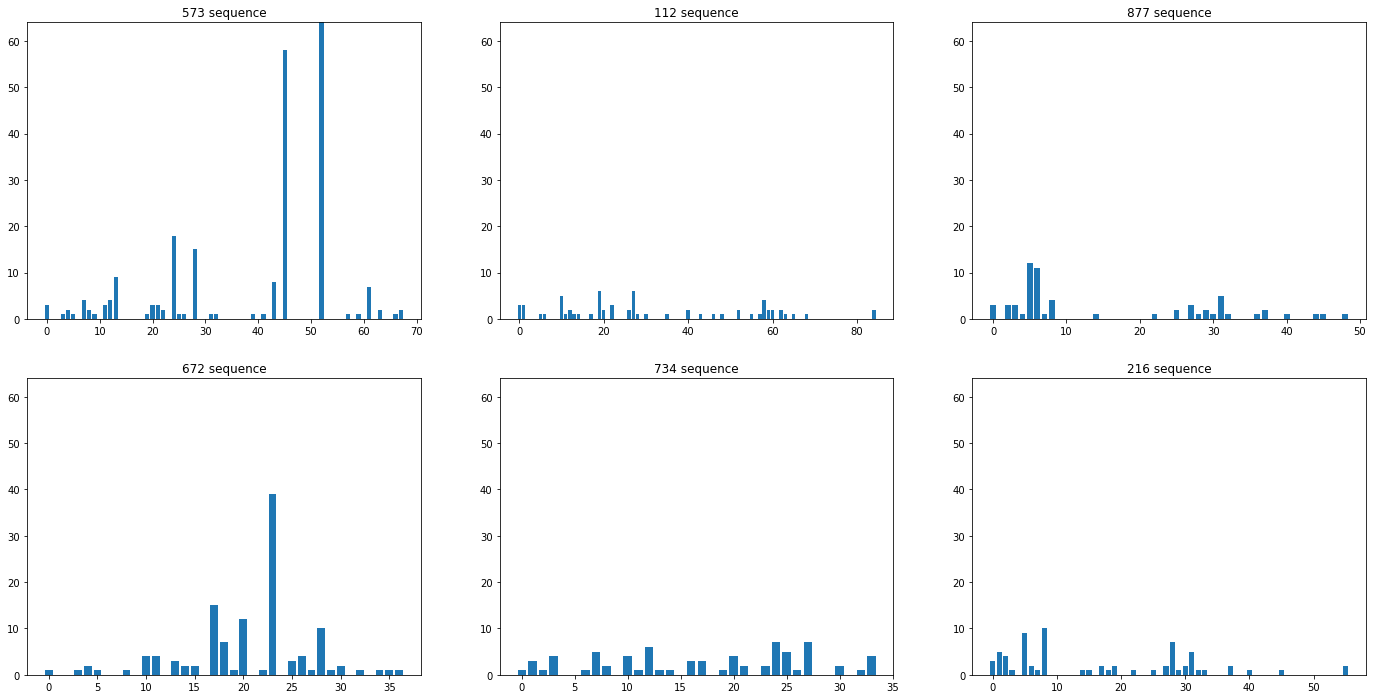

In [110]:
_ = visualize.visualize_random_sequences(tightened_train, 2, 3)
plt.savefig("examples.png", dpi=200, bbox_inches='tight')

## 3. Models

### Raw FCN

In [111]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self , tensors):
        super(CustomDataset, self).__init__()
        self.tensors = tensors

    def __getitem__(self, index):
        x = self.tensors[0][index]  
        y = self.tensors[1][index]    
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.tensors[0])

In [112]:
class SimpleFCN(torch.nn.Module):
    def __init__(self):
        super(SimpleFCN, self).__init__()
        self.fcn = torch.nn.Sequential(
            torch.nn.Conv1d(1, 16, 17, padding="same"),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(16),
            torch.nn.Conv1d(16, 32, 13),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(32),
            torch.nn.Conv1d(32, 64, 9),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Conv1d(64, 128, 5),
            torch.nn.BatchNorm1d(128),
            torch.nn.AdaptiveAvgPool1d(2),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 2)
        )
    def forward(self, X):
        return self.fcn(X)

#### No balance

In [113]:
model = SimpleFCN()
model = model.to(device)

In [114]:
def train_model(model, epochs, optima, crit, train_loader, val_loader):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    confmat = ConfusionMatrix(num_classes=2, task="binary").to(device)
    for i in tqdm(range(epochs)):
        batch_train_losses = []
        batch_train_acc = []
        train_confusion_matrix = torch.zeros((2, 2)).long().to(device)
        for X, y in train_loader:
            
            optima.zero_grad()
            
            y_pred = model(X)
            loss = crit(y_pred, y)
            y_act = torch.nn.Sigmoid()(y_pred)
            train_confusion_matrix += confmat(y_act, y)
            batch_train_acc.append(((y_act.argmax(axis=1) == y).sum() / y.shape[0]).item())
            loss.backward()
            batch_train_losses.append(loss.item())
            
            optima.step()
        batch_val_losses = []
        batch_val_acc = []
        val_confusion_matrix = torch.zeros((2, 2)).long().to(device)
        with torch.no_grad():
            for X, y in val_loader:
                y_pred = model(X)
                loss = crit(y_pred, y)
                y_act = torch.nn.Sigmoid()(y_pred)
                val_confusion_matrix += confmat(y_act, y)
                batch_val_acc.append(((y_act.argmax(axis=1) == y).sum() / y.shape[0]).item())
                batch_val_losses.append(loss.item())
        train_accuracies.append(np.mean(batch_train_acc))
        train_losses.append(np.mean(batch_train_losses))
        val_accuracies.append(np.mean(batch_val_acc))
        val_losses.append(np.mean(batch_val_losses))
        clear_output()
        fig, ax = plt.subplots(ncols=2)
        fig.set_figheight(8)
        fig.set_figwidth(16)
        ax[0].plot(np.arange(len(train_losses)), train_losses)
        ax[0].plot(np.arange(len(val_losses)), val_losses)
        ax[0].legend(['train_loss', 'val_loss'])
        ax[1].plot(np.arange(len(train_accuracies)), train_accuracies)
        ax[1].plot(np.arange(len(val_accuracies)), val_accuracies)
        ax[1].legend(['train_accuracy', 'val_accurracy'])
        plt.show()
        sns.heatmap(val_confusion_matrix.to('cpu').numpy(), annot=True)
        plt.show()
    return train_losses, val_losses
    

In [115]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.CrossEntropyLoss()

In [116]:
X_train = torch.from_numpy(Xy_train[:, :-1]).float().reshape(Xy_train.shape[0], 1, Xy_train.shape[1] - 1)
y_train = torch.from_numpy(Xy_train[:, -1] > 0).long()
X_val = torch.from_numpy(Xy_test[:, :-1]).float().reshape(Xy_test.shape[0], 1, Xy_test.shape[1] - 1)
y_val = torch.from_numpy(Xy_test[:, -1] > 0).long()

In [117]:
train_dataset = CustomDataset((X_train, y_train))
val_dataset = CustomDataset((X_val, y_val))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

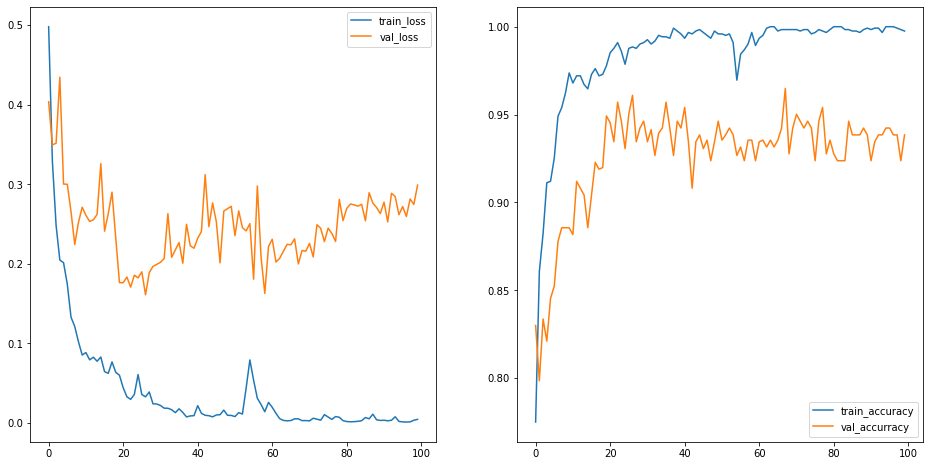

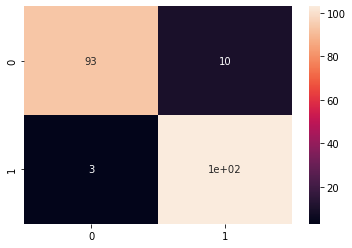

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


In [118]:
_ = train_model(model, 100, optimizer, loss, train_loader, val_loader)

In [119]:
Xy_train = np.array(train_data[:, left_idx + 1:right_idx + 1])
Xy_test = np.array(test_data[:, left_idx + 1:right_idx + 1])
X_true_test0 = np.concatenate((Xy_train, Xy_test))
X_test = torch.FloatTensor(X_true_test0[:, :-1]).to(device)
y_test = torch.LongTensor(X_true_test0[:, -1] > 0).to(device)

In [120]:
preds = []
trues = []
matrix = torch.zeros((2, 2)).to(device)
confmat = ConfusionMatrix(num_classes=2, task="binary").to(device)
ypreds = torch.argmax(torch.sigmoid(model(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]))), axis=1)
matrix += confmat(ypreds, y_test)
matrix

tensor([[576.,  27.],
        [124., 663.]], device='cuda:0')

In [121]:
accuracy = ((matrix[0, 0] + matrix[1, 1]) / matrix.sum()).item()
precision_1 = (matrix[0, 0] / (matrix[0, 0] + matrix[0, 1])).item()
recall_1 = (matrix[0, 0] / (matrix[0, 0] + matrix[1, 0])).item()
precision_0 = (matrix[1, 1] / (matrix[1, 1] + matrix[1, 0])).item()
recall_0 = (matrix[1, 1] / (matrix[1, 1] + matrix[0, 1])).item()
f1_score_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1)
f1_score_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0)
print(f"""Overall metrics:
Accuracy      : {np.round(accuracy, 3)}
Precision on 1: {np.round(precision_1, 3)}
Recall on 1   : {np.round(recall_1, 3)}
F-score on 1  : {np.round(f1_score_1, 3)}
Precision on 0: {np.round(precision_0, 3)}
Recall on 0   : {np.round(recall_0, 3)}
F-score on 0  : {np.round(f1_score_0, 3)}
""")

Overall metrics:
Accuracy      : 0.891
Precision on 1: 0.955
Recall on 1   : 0.823
F-score on 1  : 0.884
Precision on 0: 0.842
Recall on 0   : 0.961
F-score on 0  : 0.898



In [43]:
# [tp, fp]
# [fn, tn]

#### Let be balanced

In [20]:
model = SimpleFCN()
model = model.to(device)

In [21]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.CrossEntropyLoss()

X_train = torch.from_numpy(Xy_train[:, :-1]).float().reshape(Xy_train.shape[0], 1, Xy_train.shape[1] - 1)
y_train = torch.from_numpy(Xy_train[:, -1] > 0).long()
X_val = torch.from_numpy(Xy_test[:, :-1]).float().reshape(Xy_test.shape[0], 1, Xy_test.shape[1] - 1)
y_val = torch.from_numpy(Xy_test[:, -1] > 0).long()

In [22]:
y_train.sum() / y_train.shape[0]

tensor(0.2645)

In [23]:
X_train_zeros = X_train[(y_train == 0)]
X_train_ones = X_train[(y_train == 1)]
X_val_zeros = X_val[(y_val == 0)]
X_val_ones = X_val[(y_val == 1)]
X_train_ones.shape, X_train_zeros.shape

(torch.Size([2071, 1, 30]), torch.Size([5759, 1, 30]))

In [24]:
X_train_zeros = shuffle(X_train_zeros)[:X_train_ones.shape[0]]
X_val_zeros = shuffle(X_val_zeros)[:X_val_ones.shape[0]]
X_train_balanced = torch.concat((X_train_ones, X_train_zeros))
X_val_balanced = torch.concat((X_val_ones, X_val_zeros))
y_train_balanced = torch.concat((torch.ones(X_train_ones.shape[0]), torch.zeros(X_train_zeros.shape[0]))).long()
y_val_balanced = torch.concat((torch.ones(X_val_ones.shape[0]), torch.zeros(X_val_zeros.shape[0]))).long()
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced)
X_val_balanced, y_val_balanced = shuffle(X_val_balanced, y_val_balanced)

In [25]:
X_train_balanced.shape, y_train_balanced.shape

(torch.Size([4142, 1, 30]), torch.Size([4142]))

In [26]:
train_dataset = CustomDataset((X_train_balanced, y_train_balanced))
val_dataset = CustomDataset((X_val, y_val))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

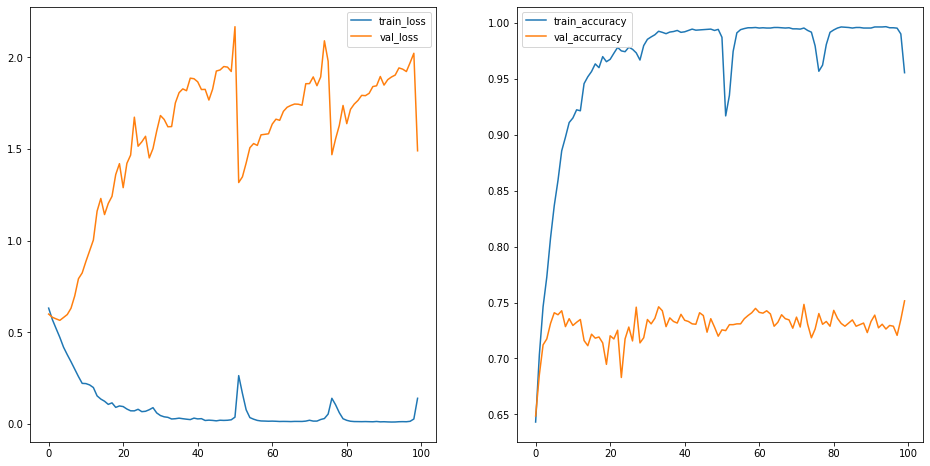

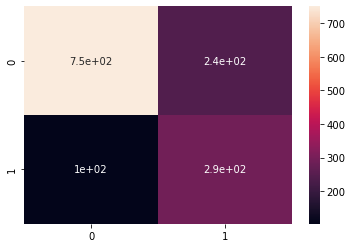

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


In [27]:
_ = train_model(model, 100, optimizer, loss, train_loader, val_loader)

### Boosting

In [11]:
Xy_train = np.array([arr[np.random.randint(0, arr.shape[0] - 61):][:61] for arr in tightened_train if arr.shape[0] >= 62])
Xy_test = np.array([arr[np.random.randint(0, arr.shape[0] - 61):][:61] for arr in tightened_test if arr.shape[0] >= 62])

In [31]:
weeks = [datetime.date(2017, 2, 1) + datetime.timedelta(days=7 * i) for i in range(Xy_train.shape[1] - 1)]

In [24]:
df["ds"] = pd.to_datetime(df["ds"])

##### Facebook Prophet

In [38]:
from prophet import Prophet

confusion_matrix = np.array([[0, 0],        # [TP(1, 1), FP(1, 0)]
                             [0, 0]])       # [FN(0, 1), TN(0, 0)]

for i in tqdm(range(Xy_train.shape[0])):
    X = Xy_train[i, :-1]
    y = Xy_train[i, -1]
    df = pd.DataFrame({"ds": weeks, "y" : X})
    clf = Prophet()   
    clf.fit(df)  
    fc = clf.make_future_dataframe(periods=1, include_history=False)
    fc = clf.predict(fc)
    result = int(fc['yhat'].values[0] > 0.5)
    is_correct = (result == y)
    if is_correct:
        confusion_matrix[1 - y, 1 - y] += 1
    elif y == 1:
        confusion_matrix[1, 0] += 1
    else:
        confusion_matrix[0, 1] += 1
    clear_output()
    print(confusion_matrix)

  2%|▏         | 47/2489 [00:46<43:18,  1.06s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[[ 2 12]
 [ 5 28]]

Initial log joint probability = -7.14817
Iteration  1. Log joint probability =    53.6963. Improved by 60.8444.
Iteration  2. Log joint probability =    54.2756. Improved by 0.579295.
Iteration  3. Log joint probability =    64.0497. Improved by 9.77414.
Iteration  4. Log joint probability =      64.25. Improved by 0.200306.
Iteration  5. Log joint probability =    64.4284. Improved by 0.178412.
Iteration  6. Log joint probability =    64.6322. Improved by 0.203819.
Iteration  7. Log joint probability =    64.8512. Improved by 0.219014.
Iteration  8. Log joint probability =    65.0347. Improved by 0.183501.
Iteration  9. Log joint probability =    65.1613. Improved by 0.126512.
Iteration 10. Log joint probability =    65.1664. Improved by 0.00510134.
Iteration 11. Log joint probability =    65.3266. Improved by 0.160245.
Iteration 12. Log joint probability =    65.3528. Improved by 0.026207.
Iteration 13. Log joint probability =    65.5418. Improved by 0.189027.
Ite

  2%|▏         | 47/2489 [00:46<40:37,  1.00it/s]


KeyboardInterrupt: 

##### Arima

In [34]:
confusion_matrix

array([[ 2,  9],
       [ 4, 18]])